In [48]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "./"

from pandas import ExcelWriter
from pandas import ExcelFile
 
df = pd.read_excel('higherEd.xlsx', sheetname='Largest gift by college')
dftop = pd.read_excel('higherEd.xlsx', sheetname='Gifts over 50M USD')

In [59]:
#IMP FUnctions

# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

#Check Nan rows
nans = lambda df: df[df.isnull().any(axis=1)]

In [49]:
df['Amount Given'] = (df['Amount Given'].astype(float)/1000000).astype(float)
df['Year'] = (df['Year Given'].astype(float))
df = df.drop(['Year Given'], axis=1)
df.head()

,College,Primary Purpose,Amount Given,Year
0,Broad Institute of Harvard University and Mass...,Psychiatric research,650.0,2014.0
1,California Institute of Technology,"To promote collaborative, interdisciplinary re...",600.0,2001.0
2,Columbia University,Medical school and New York-Presbyterian Hospital,600.0,2017.0
3,Oregon Health & Science University,Challenge/matching grant,500.0,2013.0
4,University of Oregon,New campus focused on acceleration of science,500.0,2016.0


In [50]:
dftop['Amount Given'] = (dftop['Amount Given'].astype(float)/1000000).astype(float)
dftop.head()

,College,Year,Primary Purpose,Amount Given
0,Johns Hopkins University,2018,To provide funds for need-blind admissions,1800.0
1,Broad Institute of Harvard University and Mass...,2018,Psychiatric research,650.0
2,California Institute of Technology,2001,"To promote interdisciplinary, collaborative re...",600.0
3,Columbia University,2017,Medical school and New York-Presbyterian Hospital,600.0
4,Oregon Health & Science University,2013,Matching/challenge grant,500.0


In [51]:
result = df.append([dftop])
result.shape

(147, 4)

In [52]:
result.duplicated().sum()
#result[result.duplicated(['College','Year', 'Amount Given', 'Primary Purpose'], keep=False)].shape

27

In [53]:
result = result.drop_duplicates()
result.shape

(120, 4)

In [55]:
result.sort_values(by=['Amount Given'], ascending=False).head(n=20)

,Amount Given,College,Primary Purpose,Year
0,1800.0,Johns Hopkins University,To provide funds for need-blind admissions,2018.0
1,650.0,Broad Institute of Harvard University and Mass...,Psychiatric research,2018.0
0,650.0,Broad Institute of Harvard University and Mass...,Psychiatric research,2014.0
2,600.0,Columbia University,Medical school and New York-Presbyterian Hospital,2017.0
1,600.0,California Institute of Technology,"To promote collaborative, interdisciplinary re...",2001.0
2,600.0,California Institute of Technology,"To promote interdisciplinary, collaborative re...",2001.0
4,500.0,University of Oregon,New campus focused on acceleration of science,2016.0
4,500.0,Oregon Health & Science University,Matching/challenge grant,2013.0
3,500.0,Oregon Health & Science University,Challenge/matching grant,2013.0
5,500.0,"University of California, San Francisco",Planning a new hospital,2018.0


In [46]:
result['Amount Given'].describe()

count     120.000000
mean      208.686250
std       217.070716
min         0.000002
25%        50.000000
50%       200.000000
75%       300.000000
max      1800.000000
Name: Amount Given, dtype: float64

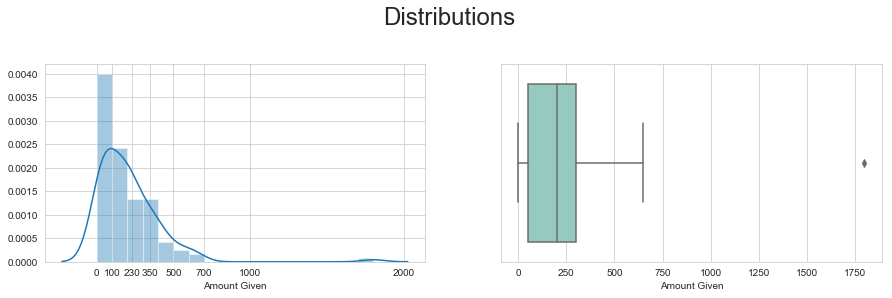

In [57]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.suptitle('Distributions', fontsize=24)

plt.subplot(2,2,1)
plt.xticks([0, 100, 230, 350, 500, 700, 1000, 2000])
#plt.xlabel('Purchase amount', fontsize=18)

sns.distplot(result['Amount Given'])

plt.subplot(2,2,2)
sns.boxplot(x=result['Amount Given'],  palette="Set3")

In [61]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(result['Primary Purpose'].apply(round1))
data_clean.shape

(120, 1)

In [62]:
from nltk.corpus import stopwords 
from textblob import TextBlob
import string 

stopwords = stopwords.words("english")

def _clean(txt):
    # lower case
    txt = txt.lower()

    # punctuation removal 
    txt = ''.join(x for x in txt if x not in string.punctuation)

    # stopwords and lemmatization
    clean_txt = ""
    for word in txt.split():
        if word in stopwords:
            continue 
        clean_txt += " "
        clean_txt += word 
    
    noise = ['students','my','title', 'would', 'every', 'will', 'many','also','donotremoveessaydivider']
    for ns in noise:
        clean_txt = clean_txt.replace(ns, "")

    return clean_txt


data_clean['Primary Purpose'] = data_clean['Primary Purpose'].apply(_clean)

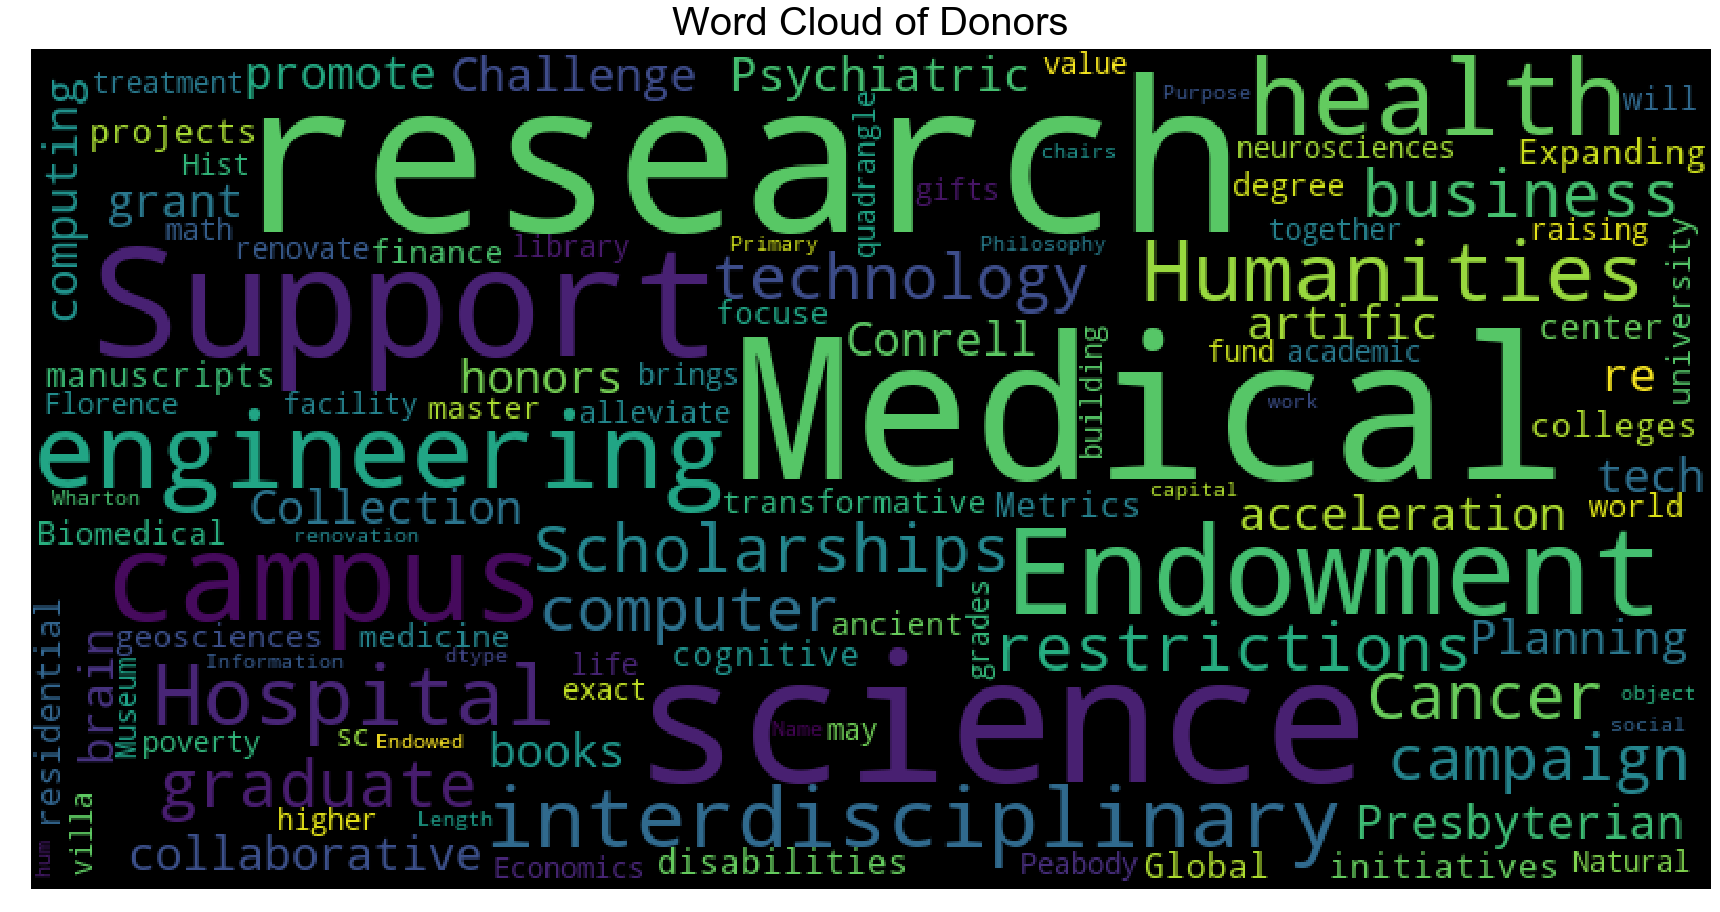

In [81]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'school', 'student', 'students', 'college', 'new', 'program', 'create', 'institute', 'study', 'matching', 'york',
                      'creating', 'city', 'department', 'rare', 'focused'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                                                     'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(result["Primary Purpose"], title="Word Cloud of Donors")

In [25]:
df['Amount Given'] = (df['Amount Given'].astype(float)/1000000).astype(str)
df = df.astype({ "Amount Given": float})
df.head()

,College,Year,Primary Purpose,Amount Given
0,Johns Hopkins University,2018,To provide funds for need-blind admissions,1800.0
1,Broad Institute of Harvard University and Mass...,2018,Psychiatric research,650.0
2,California Institute of Technology,2001,"To promote interdisciplinary, collaborative re...",600.0
3,Columbia University,2017,Medical school and New York-Presbyterian Hospital,600.0
4,Oregon Health & Science University,2013,Matching/challenge grant,500.0


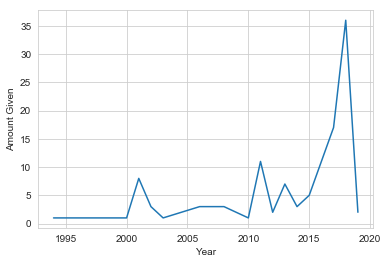

In [64]:
newdf = result.groupby(['Year'], as_index=False).count()
sns.lineplot(x="Year", y="Amount Given", data=newdf)

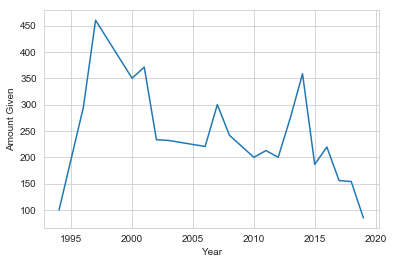

In [65]:
newdf = result.groupby(['Year'], as_index=False)['Amount Given'].mean()
sns.lineplot(x="Year", y="Amount Given", data=newdf)

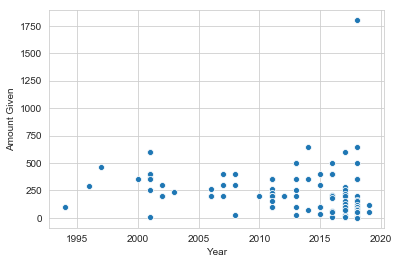

In [66]:
sns.scatterplot(x="Year", y="Amount Given", data=result)